# 不動産時系列データにカルマンフィルタを適用する

In [1]:
import sys
sys.path.append('/Users/xianshiyuming/Desktop/LDAT_LS_2019-feature_refactoring/scripts/')

In [74]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import calc_variogram as variogram
import kriging_est as kriging
import kalmanfilter as kalman

/Users/xianshiyuming/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
data = pd.read_csv('/Users/xianshiyuming/Desktop/LDAT_LS_2019-feature_refactoring/data/dev/peseudo_monthly_rent_data.csv')

In [5]:
data.head(2)

,No,都道府県,市区町村,町丁目,築年,築月,構造,マンション最上階数,間取別平均平米単価①,間取別平均平米単価②,...,最寄駅経度,始点ノード,終点ノード,最寄駅までの距離,month,月別間取別平均平米単価①,月別間取別平均平米単価②,月別間取別平均平米単価③,月別間取別平均平米単価④,月別間取別平均平米単価⑤
0,1,東京都,世田谷区,喜多見７丁目,1988,3,ＲＣ,2,2812.2742,2311.9321,...,139.587513,1.395870e+14,1.395930e+14,1096.93,9,2868.519684,2358.170742,2273.304804,2188.708860,2687.040060
1,2,東京都,世田谷区,喜多見７丁目,2005,3,鉄骨造,3,3006.8074,2633.6113,...,139.587513,1.395870e+14,1.395920e+14,930.57,3,3217.283918,2817.964091,2654.611792,2753.539712,2925.088746


In [6]:
len(data)

3852

In [7]:
data.columns = ['No', '都道府県', '市区町村', '町丁目', 'year', '築月', '構造', 'マンション最上階数',
       '間取別平均平米単価①', '間取別平均平米単価②', '間取別平均平米単価③', '間取別平均平米単価④',
       '間取別平均平米単価⑤', '物件緯度', '物件経度', '最寄駅', '最寄駅緯度', '最寄駅経度', '始点ノード',
       '終点ノード', '最寄駅までの距離', 'month', '月別間取別平均平米単価①', '月別間取別平均平米単価②',
       '月別間取別平均平米単価③', '月別間取別平均平米単価④', '月別間取別平均平米単価⑤']

In [8]:
data.columns.values

array(['No', '都道府県', '市区町村', '町丁目', 'year', '築月', '構造', 'マンション最上階数',
       '間取別平均平米単価①', '間取別平均平米単価②', '間取別平均平米単価③', '間取別平均平米単価④',
       '間取別平均平米単価⑤', '物件緯度', '物件経度', '最寄駅', '最寄駅緯度', '最寄駅経度', '始点ノード',
       '終点ノード', '最寄駅までの距離', 'month', '月別間取別平均平米単価①', '月別間取別平均平米単価②',
       '月別間取別平均平米単価③', '月別間取別平均平米単価④', '月別間取別平均平米単価⑤'], dtype=object)

## 時系列データの作成
- 分散一定の減少トレンドを描く。月-10円すると考える
- 季節性のサイクルを描く。１月から始まって12月まで。1年間
    - 1: 1.00, 2: 1.02, 3: 1.07, 4: 1.06, 5: 1.06, 6: 1.04, 7: 1.02, 8: 1.00, 9: 1.02, 10: 1.05, 11: 1.04, 12: 1.04

In [9]:
np.random.seed(1)

In [10]:
trend = 50*np.random.randn(12, 3852) - 10

In [12]:
trend.T[0]

array([ 71.21726818, -59.69905605, -60.70178294,  37.26361946,
       -40.87517201,  18.3786943 ,  66.28950513,  17.25604885,
       -18.38170899, -58.14349662,  88.64279309, -79.82871272])

In [13]:
tes = np.array([np.sum(trend.T[0][:i]) for i in range(1, 13)])

In [14]:
plt.plot(np.linspace(1, 12, 12), tes)

In [15]:
pre_name = "間取別平均平米単価①"
for i in range(0, 12):
    col_name = "price_{}".format(str(i+1))
    data[col_name] = data[pre_name] + trend.T[:, :i].sum(axis=1)
    '''if i == 1:
        data[col_name] += 2*unit
    if i == 2:
        data[col_name] += 7*unit
    if i == 3:
        data[col_name] = 6*unit
    if i == 4:
        data[col_name] += 6*unit
    if i == 5:
        data[col_name] += 4*unit
    if i == 6:
        data[col_name] += 2*unit
    if i == 8:
        data[col_name] += 2*unit
    pre_name = col_name
    '''

In [16]:
tes = data.iloc[0:1, -12:].values

In [17]:
tes[0]

array([ 2812.2742    ,  2883.49146818,  2823.79241214,  2763.0906292 ,
        2800.35424866,  2759.47907665,  2777.85777095,  2844.14727609,
        2861.40332494,  2843.02161595,  2784.87811933,  2873.52091242])

In [18]:
plt.plot(np.linspace(1, 12, 12), tes[0])

In [92]:
np.random.seed(0)
indices = np.random.randint(0, 3852, 200)

In [93]:
dat = data[data.No.isin(indices)]

In [51]:
dat.head(5)

,No,都道府県,市区町村,町丁目,year,築月,構造,マンション最上階数,間取別平均平米単価①,間取別平均平米単価②,...,price_3,price_4,price_5,price_6,price_7,price_8,price_9,price_10,price_11,price_12
2,3,東京都,世田谷区,喜多見９丁目,2001,4,ＲＣ,3,2828.1343,2675.7913,...,2804.084476,2801.787754,2808.326207,2675.060022,2616.717526,2594.674811,2588.541755,2601.208495,2614.817450,2588.546811
5,6,東京都,世田谷区,喜多見９丁目,1986,4,鉄骨造,3,2751.9814,2446.0586,...,2617.539704,2533.217246,2552.120710,2520.117363,2494.923762,2495.673572,2452.820896,2495.987711,2364.275315,2390.431800
6,7,東京都,世田谷区,喜多見９丁目,1988,6,ＲＣ,0,2797.7124,2359.8370,...,2744.158601,2761.680865,2739.193884,2771.861491,2732.440666,2699.627358,2695.629333,2687.518742,2589.727250,2477.003346
7,8,東京都,世田谷区,喜多見９丁目,1989,10,ＲＣ,4,2797.0862,2462.9246,...,2734.470806,2741.375421,2776.168496,2796.807566,2808.638482,2792.538372,2742.244149,2753.648381,2714.707920,2666.144000
10,11,東京都,世田谷区,喜多見９丁目,1998,3,鉄骨造,2,2842.8740,2402.5022,...,2828.826463,2822.568965,2838.854171,2889.628039,2929.612101,2933.718011,2900.909553,2890.812599,2805.968448,2811.197785


# 時空間krigingの実装例
- 一時点krigingによる空間相関の推定
- kalmanfilter関数による時系列krigingの実施

## Krigingによる空間相関(分散共分散行列)の推定

In [94]:
Y = np.log(dat.iloc[:, -12:].values)

In [95]:
Y.shape # 196地点, 12ヶ月分のデータ

(196, 12)

In [54]:
Y

array([[ 7.94737252,  7.93441522,  7.93883237, ...,  7.86373142,
         7.86894957,  7.85885192],
       [ 7.92007644,  7.87356142,  7.86999011, ...,  7.82243981,
         7.76822683,  7.7792293 ],
       [ 7.93655736,  7.9637916 ,  7.91722979, ...,  7.89637365,
         7.85930784,  7.81480478],
       ..., 
       [ 8.16867566,  8.15358195,  8.1358972 , ...,  8.10730476,
         8.08577206,  8.0835016 ],
       [ 8.13839831,  8.1066478 ,  8.09664545, ...,  7.99393349,
         7.99715723,  8.01008369],
       [ 8.12470571,  8.14220656,  8.13586684, ...,  8.0902159 ,
         8.09557078,  8.10597237]])

In [96]:
dum = pd.get_dummies(dat.町丁目, drop_first=True)
dum2 = pd.get_dummies(dat.構造, drop_first=True)

In [97]:
dum.head(3)

,三宿２丁目,上北沢５丁目,上用賀１丁目,上用賀４丁目,上用賀５丁目,上祖師谷５丁目,上野毛２丁目,上野毛４丁目,上馬１丁目,上馬２丁目,...,赤堤２丁目,赤堤３丁目,赤堤４丁目,赤堤５丁目,野沢１丁目,野沢２丁目,野沢３丁目,鎌田３丁目,駒沢２丁目,駒沢３丁目
83,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
85,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
90,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [57]:
dum2.head(3)

,他,鉄骨,鉄骨造,ＡＬＣ,ＨＰＣ,ＰＣ,ＲＣ,ＳＲＣ
2,0,0,0,0,0,0,1,0
5,0,0,1,0,0,0,0,0
6,0,0,0,0,0,0,1,0


In [98]:
X1 = dat[['マンション最上階数', '最寄駅までの距離', 'year']]
# X1 = X1.join(dum).join(dum2).values

In [99]:
x = kriging.sm.add_constant(X1).values

In [100]:
x_reg = kriging.sm.add_constant(X1).values

In [101]:
y1 = Y[:, 0:1]

In [102]:
resid = pd.DataFrame(kriging.sm.OLS(y1, x).fit().resid)

In [103]:
mod = kriging.sm.OLS(y1, x).fit()
params = mod.params.T

In [104]:
coords = dat[['物件経度', '物件緯度']].reset_index(drop=True)

In [105]:
resid = coords.join(resid).values

In [118]:
vario = variogram.get_diff(resid)

In [106]:
vario

(array([[ 0.00173049,  0.00255086,  0.00178922, ...,  0.00016657,
          0.00313474,  0.00327072],
        [ 0.00087598,  0.01011217,  0.00181581, ...,  0.00075032,
          0.000183  ,  0.00019222]]),
 [139.5840681, 139.6857909],
 [35.593269790000001, 35.682643509999998])

In [120]:
vario[0][1]

array([  6.79454857e-05,   5.91257189e-04,   2.65400549e-04, ...,
         1.69124047e-04,   3.66278344e-05,   4.83397142e-05])

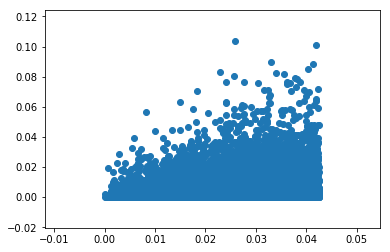

In [122]:
plt.scatter(vario[0][0], vario[0][1])

In [123]:
variogram.emp_variogram(vario[0], 11)

(array([[ 0.00198992,  0.00391574,  0.00584156,  0.00776738,  0.0096932 ,
          0.01161902,  0.01354484,  0.01547066,  0.01739648,  0.0193223 ,
          0.02124812],
        [ 0.00137508,  0.00165922,  0.00195148,  0.0022713 ,  0.00282592,
          0.00300642,  0.00377291,  0.00370615,  0.00410231,  0.00468011,
          0.00464944]]),
 array([  186.,   474.,   656.,   839.,   998.,  1103.,  1091.,  1224.,
         1244.,  1288.,  1230.]))

[ 0.          0.00259699  0.00519399  0.00779098  0.01038797  0.01298496
  0.01558196  0.01817895  0.02077594  0.02337294]
0.00610279423999 0.0150621087835


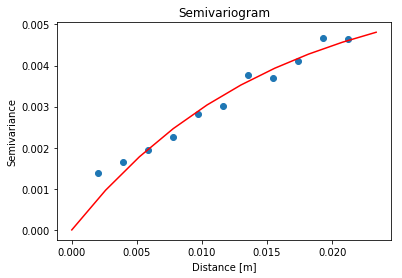

In [124]:
param, lag, fig = variogram.auto_vario(vario[0], 11, 2)

In [499]:
distance_mat = kriging.calc_distance_matrix(coords, ['物件経度', '物件緯度'])
efrange, c0 = kriging.calc_c0(param, distance_mat)

In [500]:
print(c0)

0.0005228288346280024


In [501]:
covariance_mat = kriging.est_covariance_matrix(distance_mat, param, c0)

0.0100402332173935


## 時空間krigingの実装 

In [502]:
# Settings
nt = 12
n = 196
SigP = np.identity(n+4) # 状態変数のpriorの分散
SigX = np.identity(n+4) # 状態方程式の攪乱項の分散
SigY = np.identity(n) # 観測方程式の攪乱項の分散
F = np.identity(n)
F = np.hstack([F, x_reg]) # 状態変数と観測値の関係式. Local level + Regression

In [503]:
params = params.reshape(4, 1)

In [504]:
y_pred_list = []
state_est_list = []
for t in range(2, nt+1):
    y = Y[:, t-1].reshape(n, 1)
    if t == 2:
        x = np.vstack([resid[:, 2:], params])
        SigP[0:n, 0:n] = covariance_mat # 状態変数に空間相関を想定
    else:
        x = x1
        SigP = SigP1
        F[:, -1:] = F[:, -1:] - 1
    pred, x1, SigP1, logz, a \
        = kalman.kalman(y, x, SigP, SigX, SigY, F)
    y_pred_list.append(pred)
    state_est_list.append(x1[0:n, 0:n])

In [505]:
# 地点10の結果を確認
j = 10
y_at10 = Y[j-1, :]
y_pred_at10 = [preds[j-1] for preds in y_pred_list]

In [506]:
index = np.linspace(1, 12, 12)

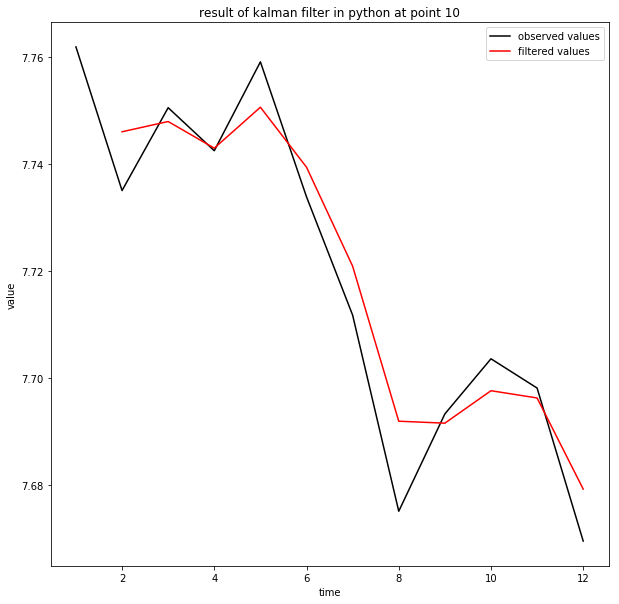

In [507]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(index, y_at10, color='black', label='observed values')
ax.plot(index[1:], y_pred_at10, color='red', label='filtered values')
ax.set_title('result of kalman filter in python at point 10')
ax.set_xlabel('time')
ax.set_ylabel('value')
ax.legend()

In [508]:
fig.savefig('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/plot/res_sptemp_kriging.png')

In [317]:
state_at10 = [preds[j-1] for preds in state_est_list]

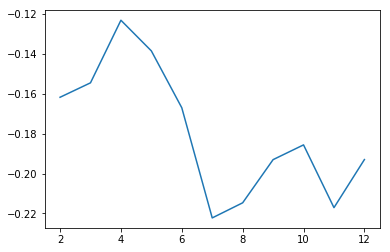

In [318]:
plt.plot(index[1:], state_at10)

In [73]:
np.random.randint(0, 3852, 200)

array([1838,  701, 2222, 1134, 2336,  231, 1943, 3773,  385, 3364,  264,
       1583, 2907, 1024,  163, 3098, 1214, 1903, 2996, 1686, 2719, 3713,
       1885, 2307,  259, 1378, 1140,  164, 2474,  366, 1044, 1257, 2181,
       2776, 1023, 3155,  694,  741, 3331, 1175, 3120, 2910,  670, 1241,
       1927,  652, 3588,  240,  923,  204, 3695,  714, 3836,  427, 3765,
        238, 3722, 2803,   43, 1798,  711, 2560,  563,  674, 2912, 3095,
       1472, 1735,  786,  800,    2, 3750, 3340, 1600,  894,  764, 3144,
       1795, 3469,  894, 2010,  131, 1254, 2502, 3718, 2452,  826, 2050,
        981,  175, 1535, 3764, 3642,  110, 1618,  254, 1616, 2361, 3755,
       1313, 3562,   69, 3293, 1103, 3161,  493, 3061, 1304,  356, 2748,
        889, 2880, 1469, 1101, 1548,  710, 1137, 2609,  131,  928, 3187,
       1713, 3811, 2445,   75, 3089,   68, 3543, 2351,  330, 2470, 2676,
       3317,  870, 2480, 1572, 1501,  793,  547, 3527,  960, 1856, 1032,
       3011, 2822, 3173, 3068, 3463,  947, 3533,   